In [587]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
from scipy.interpolate import interp1d

In [588]:
class FilterSimulation():
    
    def filter(self):
        step_response = np.load('coeff.npy')
        impulse_response = np.diff(step_response, prepend = 0)
        return impulse_response

    def convolution(self, waveform):
        impulse_response = self.filter() # step response = derivative of impulse response
        filtered_waveform = np.convolve(waveform, impulse_response, mode = 'full') # L2 regularization strength (prevents extreme values) # f(t) = h(t) * g(t)
        return filtered_waveform
    
    def interpolation(self, time, shift, filtered):
        interp_func = interp1d(shift, filtered, kind='linear', bounds_error=False, fill_value="extrapolate")
        filtered_interp = interp_func(time)  # Now same length as time_original
        return filtered_interp
    
    def plotter(self, original, time, filtered, precompensated_unfiltered, precompensated):
        plt.figure()
        plt.plot(time, original, label = 'Original')
        plt.plot(time, filtered, label = 'Filtered')
        plt.plot(time, precompensated_unfiltered, label = 'Precompensated Unfiltered', linestyle = '--')
        plt.plot(time, precompensated, label = 'Precompensated Filtered', linestyle = '--')
        plt.title('Lowpass-Filter Response')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        # plt.ylim(-0.5, 1.5)
        # plt.xlim(-0.5, 60.5)
        plt.show()

    def precompensation(self, waveform, last_index):
        impulse_response = self.filter()
        
        ir_padded = np.pad(impulse_response, (300, len(waveform)),  mode='constant')
        waveform_padded = np.pad(waveform, (300, len(impulse_response)), mode='constant', constant_values = last_index)
        
        G = fft(ir_padded)
        f_t = waveform_padded
        f_w = fft(f_t)

        reg_strength = 5e-3 # L2 regularization strength (prevents extreme values)

        G_magnitude = np.abs(G) # amplitude attenuation
        G_phase = np.angle(G) # phase shift

        # Tikhonov regularization: prevents division by zeros or near-zeros
        regularized_magnitude = G_magnitude / (G_magnitude**2 + reg_strength) # regularized version of 1/|G|
        regularized_G = regularized_magnitude * np.exp(-1j * G_phase) #INVERSE aka complex conjugate

        h_w = f_w * regularized_G
        h_t = np.real(ifft(h_w))

        return h_t
    
    def trimming(self, precompensated, CONSTANT_PADDING, last_index, n_s):
        for i in range (0, CONSTANT_PADDING):
            precompensated[i] = 0
        return precompensated

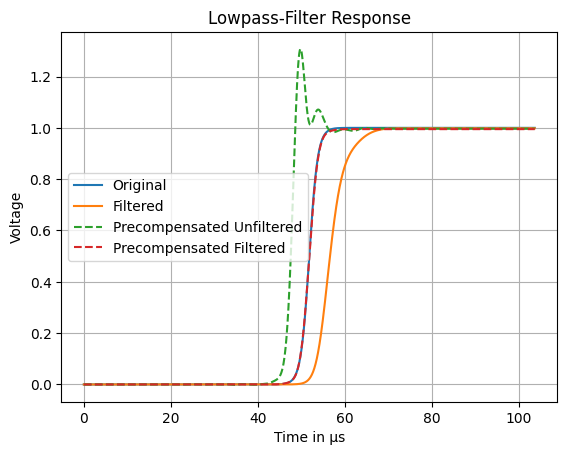

In [591]:
#Input Variables:
CONSTANT_PADDING = 400
n_s = 1030 #number of time samples (x)
t_s = 300 #number of signal samples (y)
t = 17 #microseconds total
start = -30 #Omega's bounds
stop = 30
dt = t / t_s #time step
ts = n_s - t_s

samples = np.arange(n_s + 2*CONSTANT_PADDING) #total time / total samples --> time per sample
time = (samples) * dt

w = np.linspace(start, stop, n_s) #frequency
original = 1/(1 + np.exp(-w)) #Input kind of waveform

original_padded = np.pad(original, (CONSTANT_PADDING, 0), mode='constant', constant_values=0) #pads only on left side
last_index = float(original_padded[-1])
original = np.pad(original_padded, (0, CONSTANT_PADDING), mode='constant', constant_values=last_index)

filtered = FilterSimulation().convolution(original)
shift_f =  np.arange(len(filtered)) * dt # Δt = 17 / 300 ≈ 0.0567 µs
filtered_original = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index)
FilterSimulation().trimming(precompensated, CONSTANT_PADDING, last_index, n_s)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_original = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered_interp = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

FilterSimulation().plotter(original, time, filtered_original, precompensated_unfiltered_interp, precompensated_original)

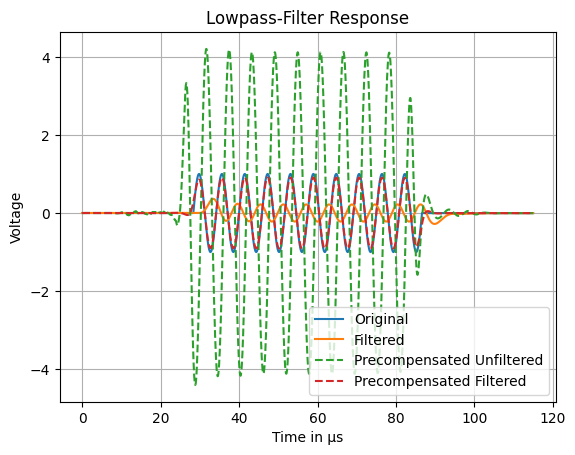

In [592]:
#Input Variables:
CONSTANT_PADDING = 500
n_s = 1030 #number of time samples (x)
t_s = 300 #number of signal samples (y)
t = 17 #microseconds total
start = -37.7 #Omega's bounds
stop = 25.13

dt = t / t_s #time step
samples = np.arange(n_s + 2*CONSTANT_PADDING) #total time / total samples --> time per sample
time = (samples) * dt

w = np.linspace(start, stop, n_s) #frequency
original = np.sin(w) #Input kind of waveform


original_padded = np.pad(original, (CONSTANT_PADDING, 0), mode='constant', constant_values=0) #pads only on left side
last_index = float(original_padded[-1])
original = np.pad(original_padded, (0, CONSTANT_PADDING), mode='constant', constant_values=last_index)

filtered = FilterSimulation().convolution(original)
shift_f =  np.arange(len(filtered)) * dt # Δt = 17 / 300 ≈ 0.0567 µs
filtered_original = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_original = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered_interp = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

FilterSimulation().plotter(original, time, filtered_original, precompensated_unfiltered_interp, precompensated_original)